In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

## Data preprocessing

Import weather data

In [ ]:
df_weather = pd.read_csv('openweathermap.csv', sep=';', decimal=",")

df_weather.drop(columns=["cod", "message", "cnt", "list__dt", "list__main__feels_like", "list__main__temp_min", "list__main__temp_max",
                        "list__main__pressure", "list__main__sea_level", "list__main__grnd_level", "list__main__temp_kf", "list__weather__id",
                        "list__weather__description", "list__weather__icon", "list__wind__deg", "list__wind__gust",
                        "list__visibility", "list__pop", "list__sys__pod", "city__id", "city__name", "list__rain__3h",
                        "city__coord__lat", "list__weather__main", "city__coord__lon", "city__country", "city__population", "city__timezone", "city__sunrise", "city__sunset"], axis = 1, inplace = True)

df_weather.rename(columns={"list__clouds__all":"Cloudiness(%)","list__dt_txt":"Datetime","list__main__temp": "Temperature(°C)", "list__main__humidity": "Humidity(%)",
                    "list__wind__speed": "Wind_speed(m/s)"}, inplace = True)

df_weather["Datetime"] = pd.to_datetime(df_weather["Datetime"])
df_weather['Temperature(°C)'] = df_weather['Temperature(°C)'] - 273.15
df_weather = df_weather.set_index('Datetime')


print(df_weather.shape)
print(df_weather.dtypes)
df_weather.head()

In [ ]:
df_weather.tail(1)

Import pv data

In [ ]:
df_pv = pd.read_csv('power_data.csv', sep=';', decimal=",")

columns_to_convert = ['Consumption', 'FeedIn', 'Production', 'Purchased', 'SelfConsumption']
df_pv["Datetime"] = pd.to_datetime(df_pv["Datetime"]).dt.tz_convert(None)
df_pv.rename(columns={'Consumption':"Consumption(W)", 'FeedIn': "FeedIn(W)", 'Production': "Production(W)", 'Purchased': "NetLoad(W)", 'SelfConsumption': "SelfConsumption(W)"}, inplace = True)
df_pv = df_pv.set_index('Datetime')

print(df_pv.dtypes)
print(df_pv.shape)
df_pv.tail()

In [ ]:
#revise the data to fit the expected timeframe (Apr29-Oct13)
df_pv = df_pv.loc['2024-04-29 09:00:00':'2024-10-13 06:00:00']
df_pv

In [ ]:
df_weather

Re-sample the weather data and concatenate the weather dataframe with the one on power data - then interpolate the weather data to fill in the missing values

In [ ]:
# Re-sample using interpolation to propagate the last known values 
# NOTE: Change interval HERE in case of different time resolution
df_weather_resampled = df_weather.resample('15T').interpolate()#.reset_index()


# Full join on the "Datetime" column + sort data again
df_merged = pd.merge(df_pv, df_weather_resampled, on='Datetime', how='outer')
df_merged.sort_values(by='Datetime', inplace=True)

df_merged.tail(20)

In [ ]:
df_merged.head(10)

In [8]:
df_merged.to_csv("resampled_and_merged.csv")

## Data visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

weather = ["Temperature(°C)","Humidity(%)","Cloudiness(%)", "Wind_speed(m/s)"]
household = ["Consumption(W)","FeedIn(W)","Production(W)","SelfConsumption(W)"]
w_xvars = df_merged[weather]
h_xvars = df_merged[household]
y_var = df_merged["NetLoad(W)"]

#df_merged.hist(bins=100, figsize=(20,15))
#plt.savefig('data_distrib.png')
#plt.show()


## Correlation analysis

To verify whether there is a statistically significant correlation between the energy purchased from the grid and the other variables (e.g., solar energy produced, total energy consumed, temperature, etc.), we use the Spearman Rank, a non-parametric test for data not normally distributed & continuous.

In [18]:
from scipy.stats import spearmanr

df_merged.dropna(inplace=True)
cols = ["Temperature(°C)", "Humidity(%)","Cloudiness(%)", "Wind_speed(m/s)","Consumption(W)","FeedIn(W)","Production(W)","SelfConsumption(W)"]
x_vars = df_merged[cols]
#y_var = df_merged["Purchased(W)"]

print("Pair \t Correlation \t P-value")
stats = []
p_vals=[]
for _,  var in x_vars.items():
    res = spearmanr(var, y_var)
    stats.append(round(res.statistic, 2))
    p_vals.append(round(res.pvalue, 2))
    print(f"NetLoad(W)-{_} \t {res.statistic} \t {res.pvalue}")

Pair 	 Correlation 	 P-value
NetLoad(W)-Temperature(°C) 	 -0.17642355541826701 	 3.6541758047182503e-112
NetLoad(W)-Humidity(%) 	 0.3064859994356478 	 0.0
NetLoad(W)-Cloudiness(%) 	 0.030609401502890498 	 0.00010664102797048094
NetLoad(W)-Wind_speed(m/s) 	 -0.22622714882996167 	 5.0482688544989684e-185
NetLoad(W)-Consumption(W) 	 -0.021693222539548966 	 0.006034354726816486
NetLoad(W)-FeedIn(W) 	 -0.6965606107975956 	 0.0
NetLoad(W)-Production(W) 	 -0.6425508078719955 	 0.0
NetLoad(W)-SelfConsumption(W) 	 -0.3588720194165845 	 0.0


In [19]:
res = spearmanr(df_merged["Cloudiness(%)"], df_merged["Production(W)"])
res.statistic

-0.06361364043591301

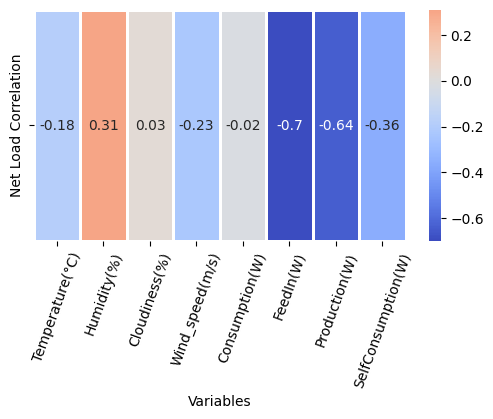

In [43]:
import seaborn as sns

data = {"Variables": cols, "Net Load Correlation": stats}
df_corr = pd.DataFrame(data)

plt.figure(figsize=(6, 3))
sns.heatmap(df_corr[["Net Load Correlation"]].set_index(df_corr['Variables']).T, annot=True, cmap='coolwarm', center=0, linewidths=1)
#plt.title('Correlation between Net Load and variables used for training', fontsize=14)
plt.xticks(rotation=70)
plt.savefig('correlation.png')
plt.show()


In [37]:
df_merged["Production(W)"].std()

1692.8538871946507

In [38]:
df_merged["Consumption(W)"].std()

716.2433545101151

In [39]:
df_merged["SelfConsumption(W)"].std()

700.3954582298303

In [40]:
df_merged["FeedIn(W)"].std()

1478.7635383769882

Re-sample the data to one-day resolution

In [ ]:
df_merged_1d = df_merged.resample('1D').agg({
    "Temperature(°C)": "mean",
    "Humidity(%)":"mean",
    "Cloudiness(%)":"mean",
    "Wind_speed(m/s)":"mean",
    "Consumption(W)":"mean",
    "FeedIn(W)":"mean",
    "Production(W)":"mean",
    "SelfConsumption(W)":"mean",
    "NetLoad(W)":"mean"
})

df_merged_1d

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


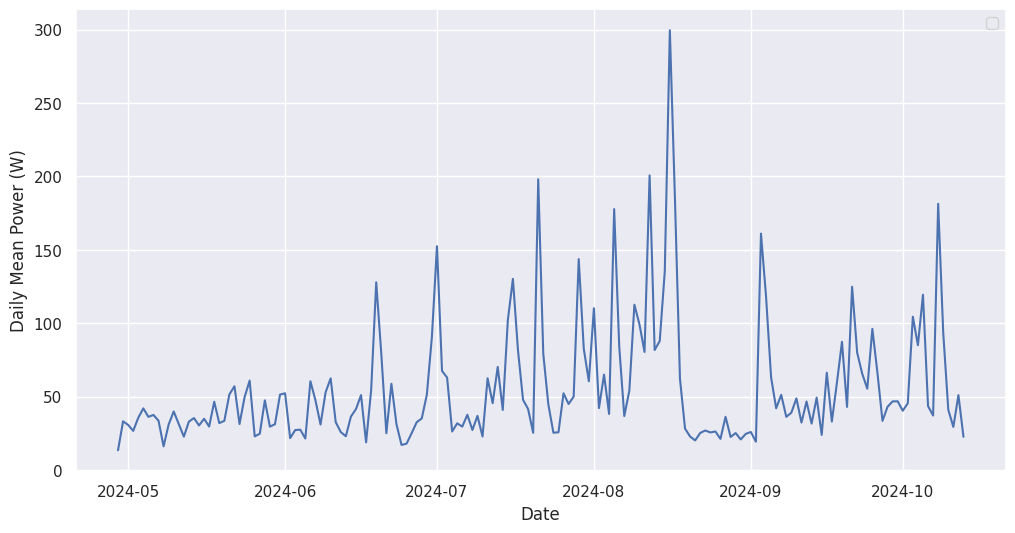

In [77]:
plt.figure(figsize=(12, 6))
#plt.plot(df_merged_1d.index, df_merged_1d['Consumption(W)'], label='Consumption(W)', marker='o')
#plt.plot(df_merged_1d.index, df_merged_1d['Production(W)'], label='Production(W)', marker='o')
plt.plot(df_merged_1d.index, df_merged_1d['NetLoad(W)'])#, label='Net Load(W)', marker='o')
plt.xlabel('Date')
plt.ylabel('Daily Mean Power (W)')
#plt.title('Daily Net Load')
plt.legend()
plt.grid(True)
plt.show()


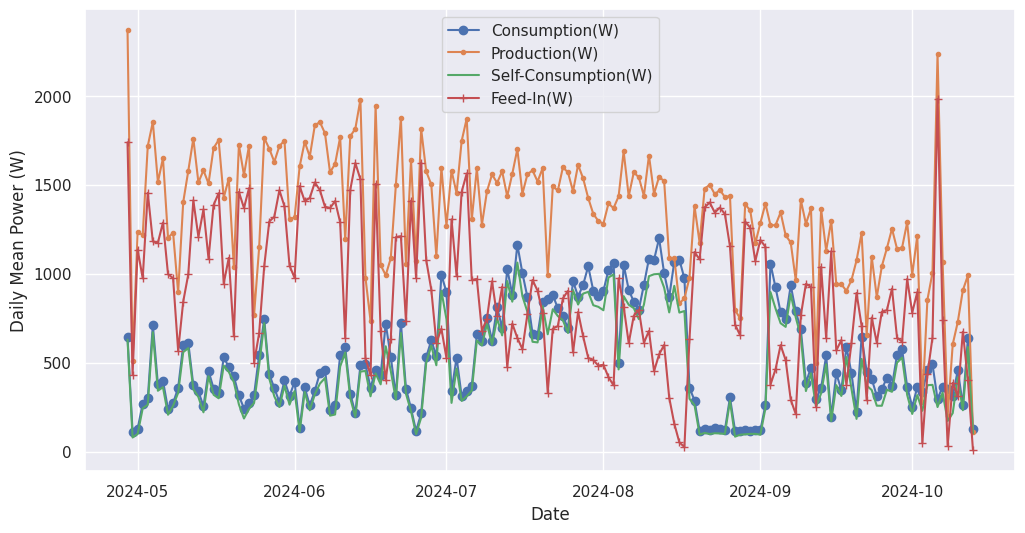

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(df_merged_1d.index, df_merged_1d['Consumption(W)'], label='Consumption(W)', marker='o')
plt.plot(df_merged_1d.index, df_merged_1d['Production(W)'], label='Production(W)', marker='.')
plt.plot(df_merged_1d.index, df_merged_1d['SelfConsumption(W)'], label='Self-Consumption(W)', marker='')
plt.plot(df_merged_1d.index, df_merged_1d['FeedIn(W)'], label='Feed-In(W)', marker='+')
plt.xlabel('Date')
plt.ylabel('Daily Mean Power (W)')
#plt.title('Daily Household Data')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


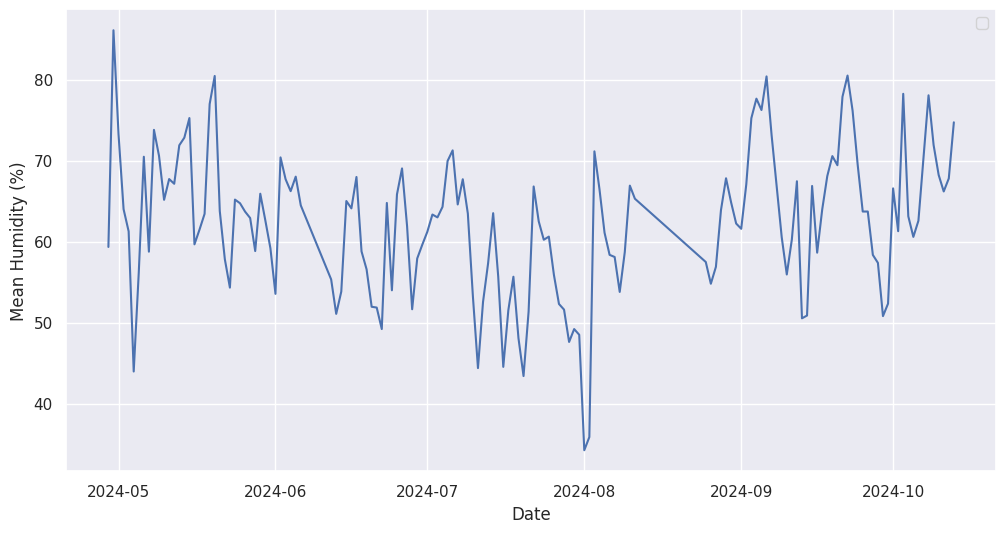

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(df_merged_1d.index, df_merged_1d['Humidity(%)'])#, label='' marker='o')
plt.xlabel('Date')
plt.ylabel('Mean Humidity (%)')
#plt.title('Daily Weather Data')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


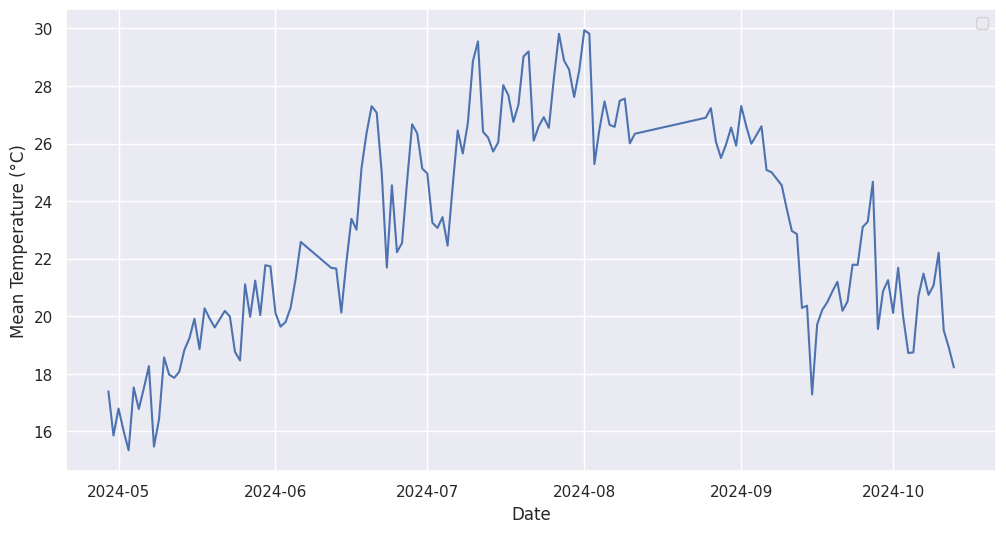

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(df_merged_1d.index, df_merged_1d['Temperature(°C)'])#, label='' marker='o')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
#plt.title('Daily Weather Data')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


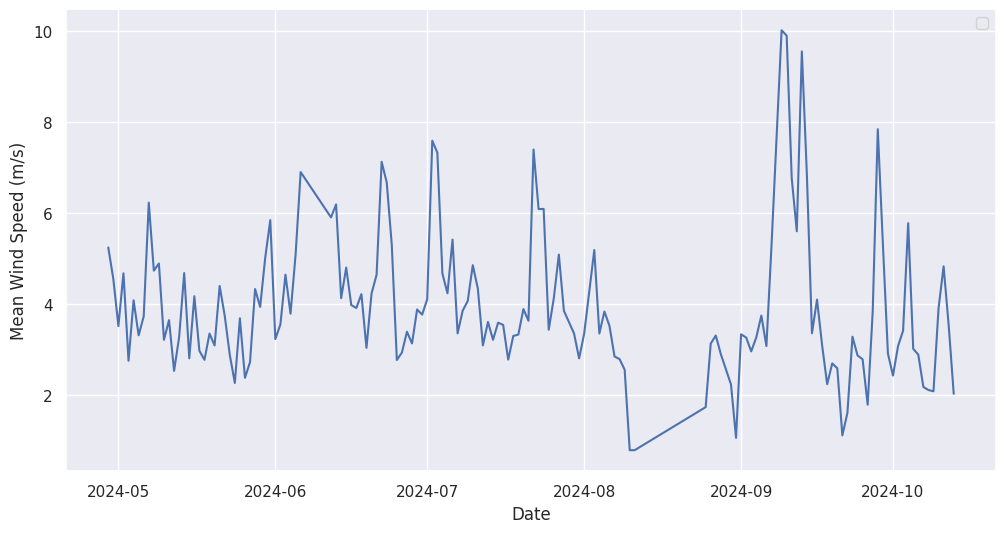

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(df_merged_1d.index, df_merged_1d['Wind_speed(m/s)'])#, label='' marker='o')
plt.xlabel('Date')
plt.ylabel('Mean Wind Speed (m/s)')
#plt.title('Daily Weather Data')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


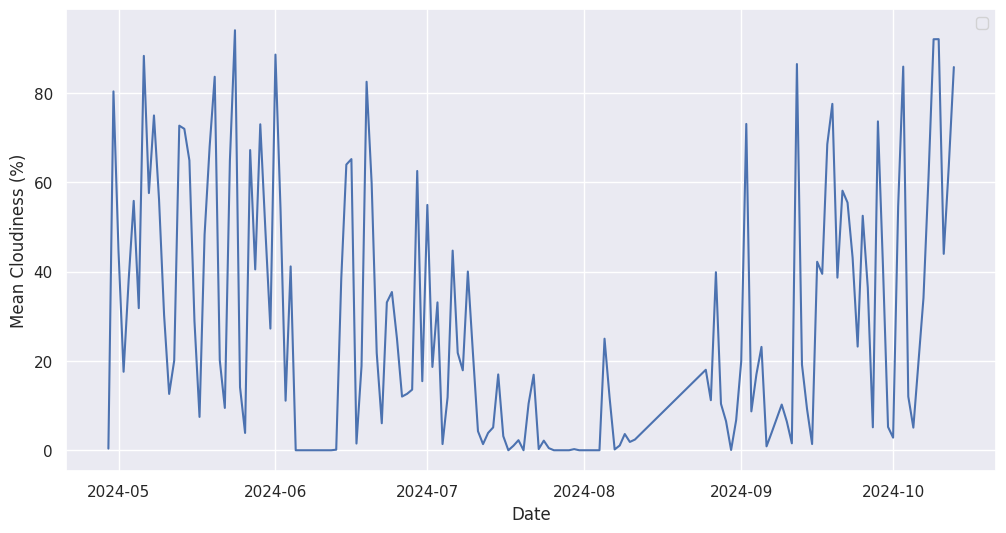

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(df_merged_1d.index, df_merged_1d['Cloudiness(%)'])#, label='' marker='o')
plt.xlabel('Date')
plt.ylabel('Mean Cloudiness (%)')
#plt.title('Daily Weather Data')
plt.legend()
plt.grid(True)
plt.show()